In [1]:
#1.1 has all networks imported 
#graphs 0 and 1 don't seem to work... 

#1.2
#things to do:
#bipartite projections
#network of islands with (1/?) distance as edge weights -> most central, etc...
#network of same species, but one node for each island 
#networkx?

#igraph 1.0

#using igraph here 

#1.1
#implementing some analysis examples
#need to incorporate weights, using 
#https://stackoverflow.com/questions/29655111/igraph-graph-from-numpy-or-pandas-adjacency-matrix

#sahara data set "Hym. Waiting�." causing problems?
#troubleshooting
#looks like it works if we just use the saharas...
#something's wrong. all "false" and no trues
#weight method is incorrect, matrices are different 

#this weight method seems ok. need to do sanity checks later 


#something is wrong with the indexing?

#big problem! something's wrong with the node labelling index technique. nodes dont match 
#let's leverage the get._incidence method. looks like it tells me how to label em! 
#http://igraph.org/python/doc/igraph.Graph-class.html#get_incidence
#so label rows first, then columns

#looks like the weight-combining of the multi edges was screwing it up! 

#1.6 
#hopefully this'll do it... 
#ok, looks good. some caveats: degree won't return weights
#need to use strength and pass the edge weights 


#to examine, try 
#zip(g[4].vs['label'], g[4].strength(weights = g[4].es['weight']))
#and
#adj[4]


#2.0
#seems good, had to nix the neighbor finding function for now (indexing wasn't right)
#may have to revisit previous codes (ie multinetx, etc...) to patch up the labeling and weights, etc...

#2.1 incorporating the location network 

#2.2 zhiya's merge tech solved everything in one instant 

#2.3 trying to incorporate multiple kinds of edges in the location network 

#ok, can add edges with separate weights in addition to the originals. 
#will call the #similiar species weight2


#2.5 making more readable

#2.6 targeted analysis

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
%reload_ext autoreload
%autoreload 2
import scipy.stats as st
import os
from scipy.optimize import curve_fit
import igraph as ig
import csv
import powerlaw as pl

import itertools as it

I'd ran into trouble with consistency in the node/network labeling before, so these are steps to make sure that
the order of the nodes in the network is consistent with the way they're imported, etc...

Import the distances between the islands into a dataframe, and create a graph that uses 1/distance as the edgeweights.

Then, create a dataframe that contains measures from the location graph

In [3]:
data = pd.read_csv("/Users/ahazarie/Desktop/U of R/Fall 2016/R-S/Current stuff/CSSS/_multilayer_graphs/sets/Plant_Pollinator_Distance_Network/Distance_between_sites_Dryad.csv")
dict1 = {'WesternSahara_1':0,
         'WesternSahara_2':1,
         'Fuerteventura_1':2,
         'Fuerteventura_2':3,
         'GranCanaria_1':4,
         'GranCanaria_2':5,
         'TenerifeSouth_1':6,
         'TenerifeSouth_2':7,
         'TenerifeTeno_1':8,
         'TenerifeTeno_2':9,
         'Gomera_1':10,
         'Gomera_2':11,
         'Hierro_1':12,
         'Hierro_2':13}


data.columns = ['From','To','Dist_m']
data['1/dist'] = 1.0 / data['Dist_m']
data = data.groupby('Dist_m').first().reset_index()

nodes = list(set(data['From'].append(data['To'])))
node_ids = range(len(nodes))
#edges and weights imported in same order, so should be consistent
edgelist = zip(data['From'],data['To'])
weights = data['1/dist']
edge_ids = []

for i in range(len(edgelist)):
    edge_ids.append((dict1[edgelist[i][0]],dict1[edgelist[i][1]]))
g_locs = ig.Graph()
g_locs.add_vertices(node_ids)
g_locs.add_edges(edge_ids)
g_locs.es['weight'] = weights
g_locs.es["width"] = ig.rescale(g_locs.es["weight"], out_range=(0.5, 3))

g_locs.vs['label'] =['WesternSahara_1',
         'WesternSahara_2',
         'Fuerteventura_1',
         'Fuerteventura_2',
         'GranCanaria_1',
         'GranCanaria_2',
         'TenerifeSouth_1',
         'TenerifeSouth_2',
         'TenerifeTeno_1',
         'TenerifeTeno_2',
         'Gomera_1',
         'Gomera_2',
         'Hierro_1',
         'Hierro_2']

loc_df = pd.DataFrame({'island':g_locs.vs['name'],
                   'island_name': g_locs.vs['label'],
                   'betweenness':g_locs.betweenness(weights = g_locs.es['weight']),
                   'pagerank': g_locs.pagerank(weights = g_locs.es['weight']),
                   'strength':g_locs.strength(weights = g_locs.es['weight'])
                   
                  })

Import the adjacency matrices (the order is important, it matches the dictionary defined in the last slide.)

In [4]:
adj = []
adj.append(pd.read_csv("/Users/ahazarie/Desktop/U of R/Fall 2016/R-S/Current stuff/CSSS/_multilayer_graphs/sets/Plant_Pollinator_Distance_Network/Site1_WesternSahara1.csv"))
adj.append(pd.read_csv("/Users/ahazarie/Desktop/U of R/Fall 2016/R-S/Current stuff/CSSS/_multilayer_graphs/sets/Plant_Pollinator_Distance_Network/Site2_WesternSahara2.csv"))
adj.append(pd.read_csv("/Users/ahazarie/Desktop/U of R/Fall 2016/R-S/Current stuff/CSSS/_multilayer_graphs/sets/Plant_Pollinator_Distance_Network/Site3_Fuerteventura1.csv"))
adj.append(pd.read_csv("/Users/ahazarie/Desktop/U of R/Fall 2016/R-S/Current stuff/CSSS/_multilayer_graphs/sets/Plant_Pollinator_Distance_Network/Site4_Fuerteventura2.csv"))
adj.append(pd.read_csv("/Users/ahazarie/Desktop/U of R/Fall 2016/R-S/Current stuff/CSSS/_multilayer_graphs/sets/Plant_Pollinator_Distance_Network/Site5_GranCanaria1.csv"))
adj.append(pd.read_csv("/Users/ahazarie/Desktop/U of R/Fall 2016/R-S/Current stuff/CSSS/_multilayer_graphs/sets/Plant_Pollinator_Distance_Network/Site6_GranCanaria2.csv"))
adj.append(pd.read_csv("/Users/ahazarie/Desktop/U of R/Fall 2016/R-S/Current stuff/CSSS/_multilayer_graphs/sets/Plant_Pollinator_Distance_Network/Site7_TenerifeSouth1.csv"))
adj.append(pd.read_csv("/Users/ahazarie/Desktop/U of R/Fall 2016/R-S/Current stuff/CSSS/_multilayer_graphs/sets/Plant_Pollinator_Distance_Network/Site8_TenerifeSouth2.csv"))
adj.append(pd.read_csv("/Users/ahazarie/Desktop/U of R/Fall 2016/R-S/Current stuff/CSSS/_multilayer_graphs/sets/Plant_Pollinator_Distance_Network/Site9_TenerifeTeno1.csv"))
adj.append(pd.read_csv("/Users/ahazarie/Desktop/U of R/Fall 2016/R-S/Current stuff/CSSS/_multilayer_graphs/sets/Plant_Pollinator_Distance_Network/Site10_TenerifeTeno2.csv"))
adj.append(pd.read_csv("/Users/ahazarie/Desktop/U of R/Fall 2016/R-S/Current stuff/CSSS/_multilayer_graphs/sets/Plant_Pollinator_Distance_Network/Site11_Gomera1.csv"))
adj.append(pd.read_csv("/Users/ahazarie/Desktop/U of R/Fall 2016/R-S/Current stuff/CSSS/_multilayer_graphs/sets/Plant_Pollinator_Distance_Network/Site12_Gomera2.csv"))
adj.append(pd.read_csv("/Users/ahazarie/Desktop/U of R/Fall 2016/R-S/Current stuff/CSSS/_multilayer_graphs/sets/Plant_Pollinator_Distance_Network/Site13_Hierro1.csv"))
adj.append(pd.read_csv("/Users/ahazarie/Desktop/U of R/Fall 2016/R-S/Current stuff/CSSS/_multilayer_graphs/sets/Plant_Pollinator_Distance_Network/Site14_Hierro2.csv"))

Construct networks from the adjacency matrices. To get the edgeweights:
The graph will create edges between nodes corresponding to the value in the adjacency cell.
To create a weighted edge, give each edge a weight 1, then collapse them using a sum to end up with a weighted edge between two nodes.

Using the get_incident method on graphs, we can find the order that the nodes are in within the graph object.
This should match the all_names list constructed, so use this method to assign attributes to the nodes (to make sure that plants are one color, bees another, etc...)



In [5]:
#name nodes
#keep a counter for j and k, j for red nodes and k for blue
#red nodes use column list, blue nodes use index

#assumes that the names are in order... (they are, by the get_incident function)

g = []


for i in range(len(adj)):
    
    g.append(ig.Graph.Incidence(adj[i].values.tolist(),multiple = True))
    g[i].es['weight'] = 1
    g[i] = g[i].simplify(combine_edges = {'weight':'sum'})
    all_names = np.append(adj[i].index.values, adj[i].columns.values)
    
    
    for j in range(len(all_names)):
        g[i].vs[j]['label'] = all_names[j]

    j = 0
    k = 0
    for l in range(g[i].vcount()):
        if (g[i].vs[l]['type']):
            g[i].vs[l]['color'] = 'red'
            j+= 1
        else:
            g[i].vs[l]['color'] = 'blue'
            k+=1 



With the graphs created, create dataframes containing useful measures from each of them. 

NOTE: These are the un-projected graph metrics. 

In [6]:
df = []
for i in range(len(g)):
    
    df.append(pd.DataFrame({'name': g[i].vs['label'], 
                            'type': g[i].vs['type'], 
                            'betweenness': g[i].betweenness(weights = g[i].es['weight']),
                           'degree': g[i].degree(),
                            'strength': g[i].strength(weights = g[i].es['weight']),
                            'pagerank': g[i].pagerank(weights = g[i].es['weight']),
                            'network': i
                           }))
    
    df[i]['id'] = df[i].index.tolist()

Create a total dataframe out of the dataframes for each graph.
This allows more of a "global" analysis approach. 


In [7]:
all_df = pd.DataFrame()
for i in range(len(df)):
    all_df = all_df.append(df[i])
all_df['num_occurences'] = 0
all_df['num_occurences'] = all_df.groupby('name').transform("count")
#all_df = all_df.reset_index()

In [8]:
#the highest strength nodes in each network
all_df.sort_values(['network','strength'],ascending = False).groupby('network').first()


#for the same thing, but restricted to different types
#all_df[all_df['type'] == False].sort_values(['network','strength'],ascending = False).groupby('network').first()
#or 
#all_df[all_df['type'] == True].sort_values(['network','strength'],ascending = False).groupby('network').first()

,betweenness,degree,name,pagerank,strength,type,id,num_occurences
network,,,,,,,,
0,510.500000,16,Euphorbia balsamifera (m),0.155922,118.0,True,39,14
1,1039.633333,22,Euphorbia balsamifera (m),0.156012,92.0,True,47,14
2,308.500000,15,Euphorbia balsamifera (m),0.172856,134.0,True,40,14
3,294.900000,16,Euphorbia balsamifera (m),0.170886,183.0,True,39,14
4,255.600000,13,Euphorbia balsamifera (m),0.132892,144.0,True,36,14
5,135.000000,7,Camponotus feae,0.158817,177.0,False,10,11
6,274.024675,12,Camponotus feae,0.206666,187.0,False,9,11
7,779.350000,16,Argyranthemum frutescens,0.103696,97.0,True,54,6
8,152.000000,12,Camponotus feae,0.153488,157.0,False,7,11


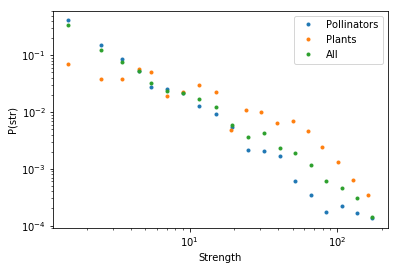

In [9]:
#plants
all_str_true = all_df[all_df['type'] == True]['strength']
all_str_true = all_str_true[all_str_true > 0]


#Pollinators
all_str_false = all_df[all_df['type'] == False]['strength']
all_str_false = all_str_false[all_str_false > 0]

pl.plot_pdf(all_str_false, label = 'Pollinators', linestyle = 'none', marker = '.')

pl.plot_pdf(all_str_true, label = 'Plants', linestyle = 'none', marker = '.')

#all 


all_str = all_df['strength']
all_str = all_str[all_str > 0]

pl.plot_pdf(all_str, label = 'All', linestyle = 'none', marker = '.')

plt.legend()

plt.xlabel('Strength')
plt.ylabel('P(str)')

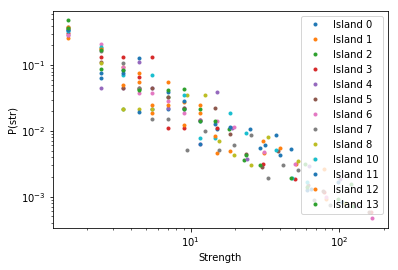

In [10]:
#every island has generalists

str_0 = all_df[all_df['network'] == 0]['strength']
str_0 = str_0[str_0 > 0]

str_1 = all_df[all_df['network'] == 1]['strength']
str_1 = str_1[str_1 > 0]

str_2 = all_df[all_df['network'] == 2]['strength']
str_2 = str_2[str_2 > 0]

str_3 = all_df[all_df['network'] == 3]['strength']
str_3 = str_3[str_3 > 0]

str_4 = all_df[all_df['network'] == 4]['strength']
str_4 = str_4[str_4 > 0]

str_5 = all_df[all_df['network'] == 5]['strength']
str_5 = str_5[str_5 > 0]

str_6 = all_df[all_df['network'] == 6]['strength']
str_6 = str_6[str_6 > 0]

str_7 = all_df[all_df['network'] == 7]['strength']
str_7 = str_7[str_7 > 0]

str_8 = all_df[all_df['network'] == 8]['strength']
str_8 = str_8[str_8 > 0]

str_9 = all_df[all_df['network'] == 9]['strength']
str_9 = str_9[str_9 > 0]

str_10 = all_df[all_df['network'] == 10]['strength']
str_10 = str_10[str_10 > 0]

str_11 = all_df[all_df['network'] == 11]['strength']
str_11 = str_11[str_11 > 0]

str_12 = all_df[all_df['network'] == 12]['strength']
str_12 = str_12[str_12 > 0]

str_13 = all_df[all_df['network'] == 13]['strength']
str_13 = str_13[str_13 > 0]

pl.plot_pdf(str_0, linestyle = 'none', marker = '.', label = 'Island 0')
pl.plot_pdf(str_1, linestyle = 'none', marker = '.', label = 'Island 1')
pl.plot_pdf(str_2, linestyle = 'none', marker = '.', label = 'Island 2')
pl.plot_pdf(str_3, linestyle = 'none', marker = '.', label = 'Island 3')
pl.plot_pdf(str_4, linestyle = 'none', marker = '.', label = 'Island 4')
pl.plot_pdf(str_5, linestyle = 'none', marker = '.', label = 'Island 5')
pl.plot_pdf(str_6, linestyle = 'none', marker = '.', label = 'Island 6')
pl.plot_pdf(str_7, linestyle = 'none', marker = '.', label = 'Island 7')
pl.plot_pdf(str_8, linestyle = 'none', marker = '.', label = 'Island 8')
pl.plot_pdf(str_10, linestyle = 'none', marker = '.', label = 'Island 10')
pl.plot_pdf(str_11, linestyle = 'none', marker = '.', label = 'Island 11')
pl.plot_pdf(str_12, linestyle = 'none', marker = '.', label = 'Island 12')
pl.plot_pdf(str_13, linestyle = 'none', marker = '.', label = 'Island 13')

plt.legend()
plt.xlabel('Strength')
plt.ylabel('P(str)')

In [11]:
mainland_dist = data[(data['From'] == 'WesternSahara_1')]
mainland_dist['dest'] = [dict1[i] for i in mainland_dist['To']]

/Users/ahazarie/.local/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [12]:
mainland_dist

,Dist_m,From,To,1/dist,dest
6,505.679714,WesternSahara_1,WesternSahara_2,0.001978,1
47,244126.100200,WesternSahara_1,GranCanaria_1,0.000004,4
48,244218.294700,WesternSahara_1,GranCanaria_2,0.000004,5
59,305014.208600,WesternSahara_1,Fuerteventura_2,0.000003,3
60,305029.086300,WesternSahara_1,Fuerteventura_1,0.000003,2
67,339317.665300,WesternSahara_1,TenerifeSouth_1,0.000003,6
68,339340.939500,WesternSahara_1,TenerifeSouth_2,0.000003,7
75,389041.274500,WesternSahara_1,TenerifeTeno_1,0.000003,8
76,389081.672300,WesternSahara_1,TenerifeTeno_2,0.000003,9
80,389999.574700,WesternSahara_1,Gomera_2,0.000003,11


In [13]:
#reverse lookup tool
dict2 = dict(map(reversed, dict1.items()))

#assigning a column to the dataframe that contains the distance to the mainland 

main_dict = dict(zip(mainland_dist.To, mainland_dist.Dist_m))
main_dict['WesternSahara_1'] = 0
all_df['to_main'] = [main_dict[dict2[i]] for i in all_df['network'].values]

In [25]:
#Euphorbia balsamifera (f) and Euphorbia balsamifera (m) occur the most, lets see how they do
#as to_main increases
all_df.sort_values('num_occurences', ascending = False).head()

,betweenness,degree,name,network,pagerank,strength,type,id,num_occurences,to_main
40,101.000000,3,Euphorbia balsamifera (f),6,0.050253,46.0,True,40,14,339317.6653
39,123.000000,5,Euphorbia balsamifera (f),2,0.064480,52.0,True,39,14,305029.0863
36,93.916667,7,Euphorbia balsamifera (m),12,0.103402,76.0,True,36,14,437366.7753
35,79.750000,5,Euphorbia balsamifera (f),12,0.047751,32.0,True,35,14,437366.7753
49,297.566667,8,Euphorbia balsamifera (f),9,0.057147,74.0,True,49,14,389081.6723


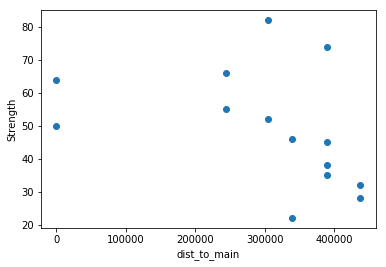

In [53]:
#doesn't look like there's a correlation

euph_f = all_df[all_df['name'] == 'Euphorbia balsamifera (f)']
plt.scatter(euph_f['to_main'], euph_f['strength'])

plt.xlabel('dist_to_main')
plt.ylabel('Strength')

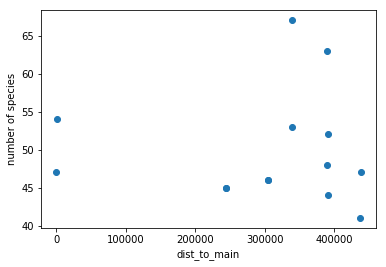

In [55]:
#try number of species 
#doesn't look like it's correlated again..


count = all_df.groupby('network').count()['type']
to_main = all_df.groupby('network').first()['to_main']


plt.xlabel('dist_to_main')
plt.ylabel('number of species')


plt.scatter(to_main,count)

In [38]:
main_species = all_df[all_df['network']==0]['name'].values

In [50]:
num_shared = all_df.groupby('network').apply(lambda x: len(set(x['name']).intersection(main_species)))

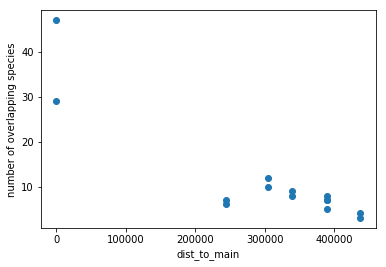

In [56]:
plt.scatter(to_main,num_shared)
plt.xlabel('dist_to_main')
plt.ylabel('number of overlapping species')